## Problem Statement

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

Start: the time consumer submits the order (created_at) to
End: when the order will be delivered to the consumer (actual_delivery_time)

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import sklearn

In [296]:
#read the historical data
df = pd.read_csv('historical_data.csv')

In [297]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [298]:
#get information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [299]:
#check for null values 
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [300]:
#change type of date fields and create target variable
from datetime import datetime 
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] =pd.to_datetime(df['actual_delivery_time'])
df['total_delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [301]:
#calculate durationt that not related to order prepration
df['non-prep_duration'] =df['estimated_order_place_duration'] + df['estimated_store_to_consumer_driving_duration']
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,non-prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0


In [302]:
#calculate busy dashers ratio based on total busy dashars and onshift dashers
df['busy_dashers_ratio'] = df['total_busy_dashers']/df['total_onshift_dashers']
df['busy_dashers_ratio']

0         0.424242
1         2.000000
2         0.000000
3         1.000000
4         1.000000
            ...   
197423    1.000000
197424    0.916667
197425    1.051282
197426    1.000000
197427    1.000000
Name: busy_dashers_ratio, Length: 197428, dtype: float64

In [303]:
#check categorical variables for encoding
df['market_id'].nunique()

6

In [304]:
df['store_id'].nunique()

6743

In [305]:
df['order_protocol'].nunique()

7

In [306]:
#create dictionary with the most frequent  categories of each store for replace null store values
store_id_unique = df['store_id'].unique().tolist()
store_id_and_category = {store_id: df[df.store_id==store_id].store_primary_category.mode() for store_id in store_id_unique}

In [307]:
#create function to replace null store values in the dataframe
def fill_na(store_id):
    try: 
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
df['no_null_store_category']=df['store_id'].apply(fill_na)

In [308]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,non-prep_duration,busy_dashers_ratio,no_null_store_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian


In [309]:
#create dummy variables for order_protocol,market_id,store_primary_category
order_protocol_dummies = pd.get_dummies(df.order_protocol)
order_protocol_dummies  = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
197423,0,0,0,1,0,0,0
197424,0,0,0,1,0,0,0
197425,0,0,0,1,0,0,0
197426,1,0,0,0,0,0,0


In [310]:
market_id_dummies = pd.get_dummies(df.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [311]:
store_primary_category_dummies = pd.get_dummies(df['no_null_store_category'])
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [312]:
#drop unneccasry columns
df_train = df.drop(columns = ['created_at','market_id','store_id','store_primary_category','actual_delivery_time','no_null_store_category','order_protocol'])
df_train .head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,non-prep_duration,busy_dashers_ratio
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


In [313]:
#concatinate dummy variables with rest of the train table
df_train = pd.concat([df_train,order_protocol_dummies, market_id_dummies,store_primary_category_dummies], axis = 1)


In [314]:
df_train.astype('float32')
df_train.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,0,0,0,0,0,0,0,0,0,0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,...,0,0,0,0,0,0,0,0,0,0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,...,0,0,0,0,0,0,0,0,0,0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,...,0,0,0,0,0,0,0,0,0,0


In [315]:
df_train.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [317]:
#check infinity values by using numpy
np.where(np.any(~np.isfinite(df_train),axis=0)==True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [318]:
#replace infinite values with null values
df_train.replace([np.inf,-np.inf],np.nan,inplace=True)
df_train.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,0,0,0,0,0,0,0,0,0,0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,...,0,0,0,0,0,0,0,0,0,0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,...,0,0,0,0,0,0,0,0,0,0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,...,0,0,0,0,0,0,0,0,0,0


In [319]:
#drop null values
df_train.dropna(inplace=True)
df_train.shape

(177070, 100)

In [320]:
#check for null values again
df_train.isna().sum().sum()

0

### Remove reduntant features anc correlated/multicollinear features

<Axes: >

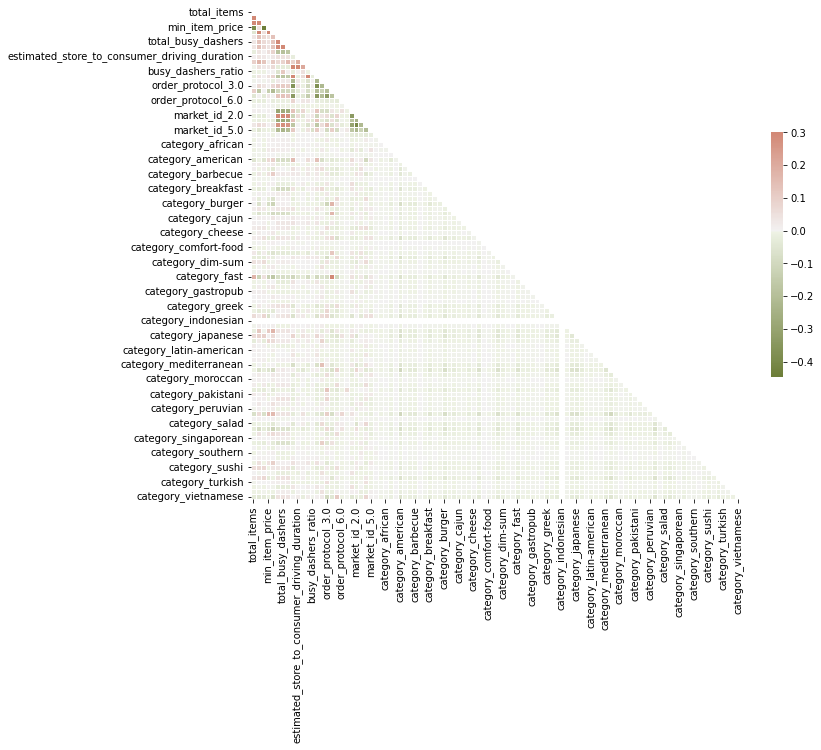

In [321]:
#create correlation matrix 
corr = df_train.corr()
#mask for upper triangle
mask = np.triu(np.ones_like(corr,dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(100,20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [322]:
df_train['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

The column above has zero variance which wont have much contribution to the model which can be dropped

In [323]:
def get_redundant_pairs(df):
    #Get diagonal and lower triangular pairs of correlation matrix

    pairs_to_drop = set()
    cols = df.columns
    
    for i in range(0,df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df,n=5):
    #Sort correlations in the descending order and return n highest results

    aur_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    aur_corr = aur_corr.drop(labels = labels_to_drop).sort_values(ascending=False)
    return aur_corr[0:n]

#print top 20 correlated features
print('Top Absolute Correlations')
print(get_top_abs_correlations(df_train,20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers          0.941741
                                              total_outstanding_orders    0.934639
total_busy_dashers                            total_outstanding_orders    0.931295
estimated_store_to_consumer_driving_duration  non-prep_duration           0.923086
estimated_order_place_duration                order_protocol_1.0          0.897645
total_items                                   num_distinct_items          0.758146
subtotal                                      num_distinct_items          0.682890
total_items                                   subtotal                    0.557175
min_item_price                                max_item_price              0.541241
subtotal                                      max_item_price              0.507947
order_protocol_4.0                            category_fast               0.489946
num_distinct_items                            min_item_price 

In [326]:
## drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol

df_train = df.drop(columns = ['created_at','market_id','store_id','store_primary_category','actual_delivery_time','no_null_store_category','order_protocol'])
#concat dummy variable except market id
df_train = pd.concat([df_train, order_protocol_dummies, store_primary_category_dummies],axis=1)



In [327]:
# drop highly correlated features
df_train = df_train.drop(columns=['non-prep_duration',"total_onshift_dashers", "total_busy_dashers", "category_indonesian",])
#implement previous steps to drop infinite values
df_train = df_train.astype('float32')
df_train.replace([np.inf,-np.inf],np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [328]:
df_train.shape

(177070, 90)

In [329]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_train, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

In [330]:
df_train = df.drop(columns = ['created_at','market_id','store_id','store_primary_category','actual_delivery_time','no_null_store_category','order_protocol'])
#concat all dummy variables excep order_protocol and market_id
df_train = pd.concat([df_train,store_primary_category_dummies],axis=1)
#drop highly correlated features
df_train = df_train.drop(columns=['non-prep_duration',"total_onshift_dashers", "total_busy_dashers", "category_indonesian",])

#implement previous steps to drop infinite values
df_train = df_train.astype('float32')
df_train.replace([np.inf,-np.inf],np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [331]:
print(get_top_abs_correlations(df_train, 20))


total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.188418
subtotal                                      total_delivery_duration           0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
max_item_price       

since total_items and num_distinct_items can affect order prep, instead of dropping those variables, we will create new variables to infer their contribution

In [332]:
df_train['percent_distinct_item'] = df_train['num_distinct_items']/df_train['total_items']
df_train['avg_price_per_item'] = df_train['subtotal']/df_train['total_items']
df_train.drop(columns=['num_distinct_items','subtotal'],inplace=True)

print(get_top_abs_correlations(df_train, 20))


min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item             0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item                         avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.188418
max_item_price                                percent_distinct_item             0.178021
category_fast                                 avg_price_per_item                0.175950
min_item_price       

In [333]:
#create new price column based on max and min item prices
df_train['price range of items'] = df_train['max_item_price'] - df_train['min_item_price']
df_train.drop(columns = ['max_item_price','min_item_price'], inplace=True)

get_top_abs_correlations(df_train, 20)

total_items                                   percent_distinct_item             0.445751
                                              price range of items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item                         avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      total_delivery_duration           0.157604
category_fast        

### Multicollinearity Check

In [240]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [241]:
features = df_train.drop(columns=['total_delivery_duration']).columns.tolist()


In [334]:
#crete function to calculate variance_inflation_factor
def compute_vif(features):
    vif_data = pd.DataFrame()
    vif_data['feature']=features
    vif_data['VIF'] = [variance_inflation_factor(df_train[features],i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)


In [350]:
# apply VIF computation to all columns of the dataframe
features = df_train.drop(columns=['total_delivery_duration']).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000370
1,category_chocolate,1.000489
2,category_belgian,1.000749
3,category_russian,1.003226
4,category_african,1.003821
...,...,...
76,busy_dashers_ratio,6.369593
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210811
79,estimated_order_place_duration,13.472028


In [349]:
## drop with highest vif score until all vif scores are under 20

multicoll=True

while multicoll:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print('I will remove', highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicoll = False if len(vif_data[vif_data.VIF>20])==0 else True
selected_features = vif_data['feature'].values.tolist()


I will remove estimated_order_place_duration


ValueError: list.remove(x): x not in list

In [245]:
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000362
2,category_belgian,1.000451
3,category_russian,1.002017
4,category_gluten-free,1.002364
...,...,...
75,category_american,4.505926
76,avg_price_per_item,5.958958
77,busy_dashers_ratio,6.357883
78,estimated_store_to_consumer_driving_duration,7.192610


### Feature selection based on their importance

In [338]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df_train[selected_features]
y= df_train['total_delivery_duration']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

<Axes: >

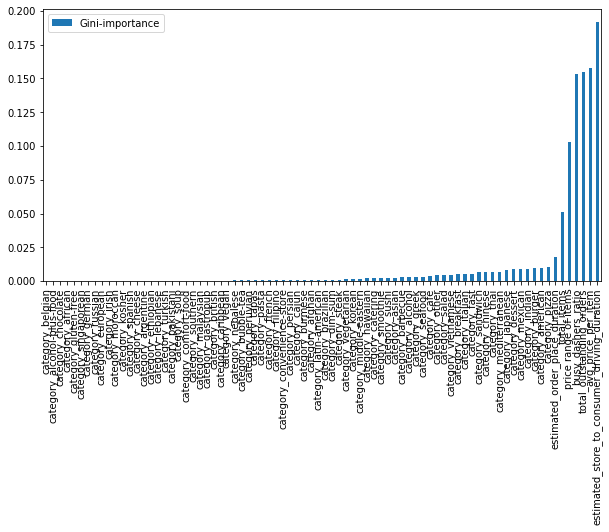

In [353]:
feature_names= [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train,y_train)
feats={}

for feature, importance in zip(X.columns,forest.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats,orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(10,5))

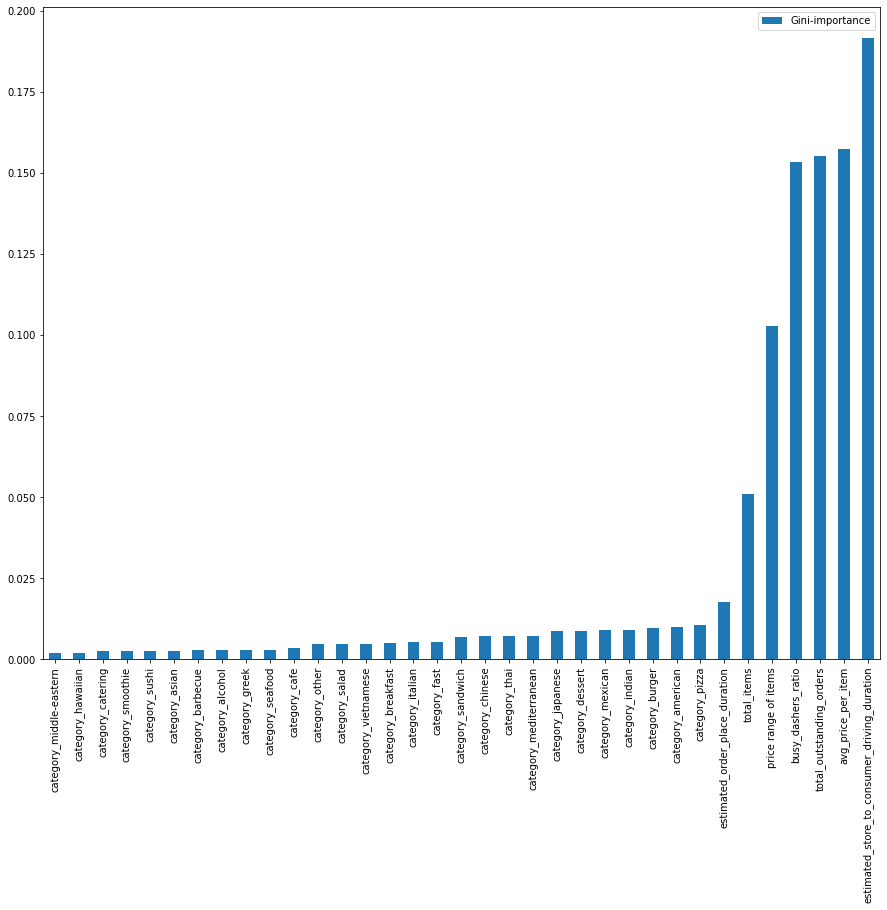

In [248]:
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

In [249]:
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price range of items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

<ipython-input-250-efc8257d7c3b>:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


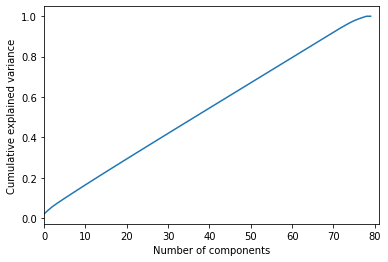

In [250]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#apply PCA to see feature contributions
X_t = X_train.values
X_t =np.asanyarray(X_train)

X_std = StandardScaler().fit_transform(X_t)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Since PCA shows that we need at least 60 features to explain 80% of the dataset and we already have 80 variables and most important features can be selected from those, we wont use PCA for our analysis

In [251]:
#create scale function to scale input data for machine learning models
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler,X,y):
    
    X_scaler = scaler
    X_scaled = X_scaler.fit_transform(X)
    y_scaler = scaler 
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1,1))
    
    return X_scaled,y_scaled,X_scaler,y_scaler

In [252]:
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X,y)

In [253]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled,y_scaled,test_size=0.2, random_state=42)

In [254]:
# create inverse transformation functions to revert scaling for predictions so  errors between actual and prediction can be calculated
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler,y_test,y_pred_scaled, model_name):
    'Convert scaled error into actual error'
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    rmse_error = mean_squared_error(y_test,y_predict[:,0],squared=False)
    print("Error = "'{}'.format(rmse_error)+ " in " + model_name)
    
    return rmse_error, y_predict
    

In [255]:
#creating regression function to work with multiple machine learning models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    model.fit(X_train,y_train)
    y_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test,y_predict, squared=False)
    
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(train_error)+" in " + model_name)
        
    trained_model = model 
    
    
    return model_name, y_predict, train_error, test_error

In [256]:
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm 
from sklearn import neighbors
from sklearn import linear_model


pred_dict = {
    'regression_model': [],
    'feature_set': [],
    'scaler_name':[],
    'RMSE':[]
}

regression_model = {
    'Ridge': linear_model.Ridge(),
    'DecisionTree':tree.DecisionTreeRegressor(max_depth=6),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'MLP': MLPRegressor()
}

feature_sets = {
    'full dataset': X.columns.to_list(),
    'selected_features_40': importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    'selected_features_20': importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    'selected_features_10': importances.sort_values(by='Gini-importance')[-10:].index.tolist()
}

scalers = {
    
    'Standard scaler': StandardScaler(),
    'MinMax scaler': MinMaxScaler(),
    'NotScale':None
}

for feature_set_name in feature_sets.keys():
    
    feature_set = feature_sets[feature_set_name]
    
    for scaler_name in scalers.keys():
        print(f"---scaled with {scaler_name}-- included columns are {feature_set_name}")
        print("")
        
        for model_name in regression_model.keys():
            
            if scaler_name == 'NotScale':
                X = df_train[feature_set]
                y  = df_train['total_delivery_duration']
                X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
                make_regression(X_train,y_train, X_test, y_test, regression_model[model_name], model_name, verbose=True)
            else:
                X_scaled,y_scaled,X_scaler,y_scaler = scale(scalers[scaler_name],X[feature_set],y)
                X_train_scaled, X_test_scaled,y_train_scaled,y_test_scaled = train_test_split(X_scaled,y_scaled,test_size=0.2,random_state=42)
                _,y_predict_scaled,_,_ = make_regression(X_train_scaled,y_train_scaled[:,0],X_test_scaled,y_test_scaled[:,0], regression_model[model_name],model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler,y_test,y_predict_scaled,model_name)
                
            pred_dict['regression_model'].append(model_name)
            pred_dict['feature_set'].append(feature_set_name)
            pred_dict['scaler_name'].append(scaler_name)
            pred_dict['RMSE'].append(rmse_error)
                                                         

---scaled with Standard scaler-- included columns are full dataset

Error = 2053.69873046875 in Ridge
Error = 2057.2476687088733 in DecisionTree
Error = 2048.156442630134 in RandomForest
Error = 2036.2498779296875 in XGBoost
Error = 2040.90087890625 in MLP
---scaled with MinMax scaler-- included columns are full dataset

Error = 2053.962890625 in Ridge
Error = 2057.2476685732177 in DecisionTree
Error = 2048.4002951694315 in RandomForest
Error = 2035.351318359375 in XGBoost
Error = 2142.233642578125 in MLP
---scaled with NotScale-- included columns are full dataset

Train error = 1071.4971923828125 in Ridge
Test error = 1071.4971923828125 in Ridge


/Users/ulvijafarli/miniconda3/envs/TFmacos/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.42546e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1067.7815291116704 in DecisionTree
Test error = 1067.7815291116704 in DecisionTree
Train error = 397.75755323437596 in RandomForest
Test error = 397.75755323437596 in RandomForest
Train error = 968.2471313476562 in XGBoost
Test error = 968.2471313476562 in XGBoost


/Users/ulvijafarli/miniconda3/envs/TFmacos/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1056.2249755859375 in MLP
Test error = 1056.2249755859375 in MLP
---scaled with Standard scaler-- included columns are selected_features_40

Error = 2054.00439453125 in Ridge
Error = 2056.5292024696128 in DecisionTree
Error = 2046.5111266409829 in RandomForest
Error = 2035.453369140625 in XGBoost
Error = 2039.069091796875 in MLP
---scaled with MinMax scaler-- included columns are selected_features_40

Error = 2054.27734375 in Ridge
Error = 2056.5292023632996 in DecisionTree
Error = 2048.5069582887995 in RandomForest
Error = 2034.2847900390625 in XGBoost
Error = 2149.439453125 in MLP
---scaled with NotScale-- included columns are selected_features_40

Train error = 1072.35498046875 in Ridge
Test error = 1072.35498046875 in Ridge


/Users/ulvijafarli/miniconda3/envs/TFmacos/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.55928e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1067.785563647774 in DecisionTree
Test error = 1067.785563647774 in DecisionTree
Train error = 397.33560382585347 in RandomForest
Test error = 397.33560382585347 in RandomForest
Train error = 965.6858520507812 in XGBoost
Test error = 965.6858520507812 in XGBoost
Train error = 1057.1595458984375 in MLP
Test error = 1057.1595458984375 in MLP
---scaled with Standard scaler-- included columns are selected_features_20

Error = 2055.36572265625 in Ridge
Error = 2054.610311207463 in DecisionTree
Error = 2048.0788496137898 in RandomForest
Error = 2037.6336669921875 in XGBoost
Error = 2036.0714111328125 in MLP
---scaled with MinMax scaler-- included columns are selected_features_20

Error = 2055.653076171875 in Ridge
Error = 2054.6103112689557 in DecisionTree
Error = 2049.058718606124 in RandomForest
Error = 2036.5164794921875 in XGBoost
Error = 2181.425537109375 in MLP
---scaled with NotScale-- included columns are selected_features_20

Train error = 1074.506591796875 in Ridge
Te

/Users/ulvijafarli/miniconda3/envs/TFmacos/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.43865e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1069.1350906055598 in DecisionTree
Test error = 1069.1350906055598 in DecisionTree
Train error = 398.5578111528773 in RandomForest
Test error = 398.5578111528773 in RandomForest
Train error = 966.1651000976562 in XGBoost
Test error = 966.1651000976562 in XGBoost
Train error = 1056.6312255859375 in MLP
Test error = 1056.6312255859375 in MLP
---scaled with Standard scaler-- included columns are selected_features_10

Error = 2056.568359375 in Ridge
Error = 2054.5971761770547 in DecisionTree
Error = 2051.62660658749 in RandomForest
Error = 2040.27001953125 in XGBoost
Error = 2040.105712890625 in MLP
---scaled with MinMax scaler-- included columns are selected_features_10

Error = 2056.882080078125 in Ridge
Error = 2054.5971762373274 in DecisionTree
Error = 2051.293859353987 in RandomForest
Error = 2039.515625 in XGBoost
Error = 2176.300537109375 in MLP
---scaled with NotScale-- included columns are selected_features_10

Train error = 1076.7279052734375 in Ridge
Test error = 1

In [257]:
pred_df = pd.DataFrame(pred_dict)

In [258]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,2053.698730
1,DecisionTree,full dataset,Standard scaler,2057.247669
2,RandomForest,full dataset,Standard scaler,2048.156443
3,XGBoost,full dataset,Standard scaler,2036.249878
4,MLP,full dataset,Standard scaler,2040.900879
5,Ridge,full dataset,MinMax scaler,2053.962891
6,DecisionTree,full dataset,MinMax scaler,2057.247669
7,RandomForest,full dataset,MinMax scaler,2048.400295
8,XGBoost,full dataset,MinMax scaler,2035.351318
9,MLP,full dataset,MinMax scaler,2142.233643


<Axes: >

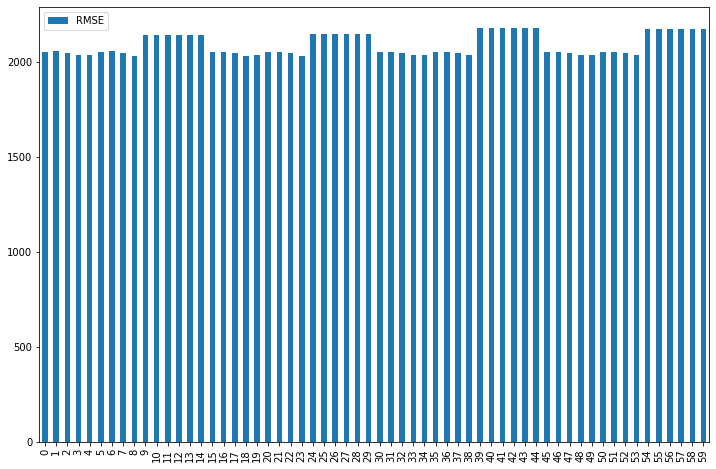

In [259]:
pred_df.plot(kind='bar', figsize=(12,8))

In [362]:
df_train['prep_time'] = df_train['total_delivery_duration'] - df_train["estimated_store_to_consumer_driving_duration"] - df_train["estimated_order_place_duration"]
df_train.head()

,total_items,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,...,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese,percent_distinct_item,avg_price_per_item,price range of items,prep_time
0,4.0,21.0,446.0,861.0,3779.0,0.424242,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,860.25,682.0,2472.0
1,1.0,2.0,446.0,690.0,4024.0,2.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1900.00,0.0,2888.0
2,1.0,0.0,446.0,690.0,1781.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1900.00,0.0,645.0
3,6.0,2.0,446.0,289.0,3075.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,1150.00,1200.0,2340.0
4,3.0,9.0,446.0,650.0,2390.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1300.00,500.0,1294.0


In [363]:
scalers ={
    'Standard sclaer': MinMaxScaler()
    
}

regression_model = {
    'Ridge': linear_model.Ridge(),
    'DecisionTree':tree.DecisionTreeRegressor(max_depth=6),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'MLP': MLPRegressor()
}

feature_sets = {
    
    'selected_features_40': importances.sort_values(by='Gini-importance')[-40:].index.tolist()
}


for i in feature_sets.keys(): 
    feature_set = feature_sets[i]
    
    for scaler_name in scalers.keys():
         print(f"-----scaled with {scaler_name}-------- included columns are {i}")
         print("")
        
         for model_name in regression_model.keys():
            
            X = df_train[feature_set].drop(columns = [ "estimated_order_place_duration",'estimated_store_to_consumer_driving_duration'])
            y = df_train['prep_time']
            
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=42)
            #obtain indices
            train_indices = X_train.index
            test_indices = X_test.index
            
            #scaleing the input data
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name],X,y)
            _,y_predict_scaled,_,_ = make_regression(X_train_scaled,y_train_scaled[:,0], X_test_scaled,y_test_scaled[:,0],regression_model[model_name],model_name, verbose=False)
            
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler,y_test,y_predict_scaled,model_name)
            
            pred_dict['regression_model'].append(model_name)
            pred_dict['feature_set'].append(feature_sets.keys())
            pred_dict['scaler_name'].append(scaler_name)
            pred_dict['RMSE'].append(rmse_error)

-----scaled with Standard sclaer-------- included columns are selected_features_40

Error = 2069.553466796875 in Ridge
Error = 2063.6623742716624 in DecisionTree
Error = 2065.6380733760298 in RandomForest
Error = 2052.968994140625 in XGBoost
Error = 2069.931396484375 in MLP


In [364]:
scalers ={
    'Standard sclaer': MinMaxScaler()
    
}

feature_sets = {
    
    'selected_features_40': importances.sort_values(by='Gini-importance')[-40:].index.tolist()
}

regression_model_xgb = {
  'XGBoost': XGBRegressor(),

}

for i in feature_sets.keys(): 
    feature_set = feature_sets[i]
    
    for scaler_name in scalers.keys():
         print(f"-----scaled with {scaler_name}-------- included columns are {i}")
         print("")
        
         for model_name in regression_model_xgb.keys():
            
            X = df_train[feature_set].drop(columns = ["estimated_order_place_duration"])
            y = df_train['prep_time']
            
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=42)
            #obtain indices
            train_indices = X_train.index
            test_indices = X_test.index
            
            #scaleing the input data
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name],X,y)
            _,y_predict_scaled,_,_ = make_regression(X_train_scaled,y_train_scaled[:,0], X_test_scaled,y_test_scaled[:,0],regression_model_xgb[model_name],model_name, verbose=False)
            
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler,y_test,y_predict_scaled,model_name)
            
            pred_dict['regression_model'].append(model_name)
            pred_dict['feature_set'].append(feature_set_name)
            pred_dict['scaler_name'].append(scaler_name)
            pred_dict['RMSE'].append(rmse_error)

-----scaled with Standard sclaer-------- included columns are selected_features_40

Error = 2052.968994140625 in XGBoost


In [359]:
pred_values_dict = {
    'total_delivery_duration': df_train['total_delivery_duration'][test_indices].values.tolist(),
    'prep_time_prediction':y_predict[:,0].tolist(),
    'estimated_store_to_consumer_driving_duration': df_train["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    'estimated_order_place_duration': df_train['estimated_order_place_duration'][test_indices].values.tolist()

}
pred_values_dict 

{'total_delivery_duration': [2448.0,
  1839.0,
  1927.0,
  2657.0,
  3596.0,
  1128.0,
  3102.0,
  3124.0,
  7824.0,
  2863.0,
  2345.0,
  4644.0,
  2225.0,
  2575.0,
  2154.0,
  2958.0,
  3684.0,
  2381.0,
  3501.0,
  3672.0,
  2302.0,
  3328.0,
  2123.0,
  1901.0,
  3222.0,
  3185.0,
  6727.0,
  2104.0,
  3864.0,
  2071.0,
  3746.0,
  1640.0,
  1073.0,
  4517.0,
  2896.0,
  2694.0,
  2632.0,
  2307.0,
  1675.0,
  4074.0,
  3382.0,
  1926.0,
  2170.0,
  2796.0,
  2953.0,
  3385.0,
  1652.0,
  2346.0,
  3051.0,
  3225.0,
  5471.0,
  1734.0,
  4580.0,
  1670.0,
  3782.0,
  1562.0,
  2147.0,
  2595.0,
  2848.0,
  1916.0,
  2869.0,
  2369.0,
  4238.0,
  4140.0,
  3050.0,
  2117.0,
  6924.0,
  3091.0,
  3190.0,
  4296.0,
  1688.0,
  1899.0,
  6386.0,
  1730.0,
  1595.0,
  2353.0,
  1562.0,
  2825.0,
  2329.0,
  2429.0,
  1758.0,
  2108.0,
  2132.0,
  3239.0,
  1667.0,
  3293.0,
  2112.0,
  4359.0,
  3449.0,
  2152.0,
  2350.0,
  2996.0,
  2403.0,
  2941.0,
  2423.0,
  2681.0,
  1232.0,
  2

In [356]:
values_df  = pd.DataFrame.from_dict(pred_values_dict)
values_df

,total_delivery_duration,prep_time_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,2091.589355,380.0,251.0
1,1839.0,2670.374512,747.0,446.0
2,1927.0,2880.587646,543.0,251.0
3,2657.0,2234.953857,445.0,251.0
4,3596.0,3060.452393,691.0,446.0
...,...,...,...,...
35409,9557.0,3926.672363,768.0,446.0
35410,1864.0,2883.315674,324.0,446.0
35411,2674.0,2956.689453,791.0,251.0
35412,2234.0,2914.633789,687.0,251.0


In [265]:
values_df['sum_total_delivery'] = values_df['total_delivery_duration']+values_df['estimated_order_place_duration']+values_df['estimated_store_to_consumer_driving_duration']
values_df

,total_delivery_duration,prep_time_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery
0,2448.0,1319.110229,380.0,251.0,3079.0
1,1839.0,1897.465210,747.0,446.0,3032.0
2,1927.0,2107.522217,543.0,251.0,2721.0
3,2657.0,1462.368042,445.0,251.0,3353.0
4,3596.0,2287.253174,691.0,446.0,4733.0
...,...,...,...,...,...
35409,9557.0,3152.829590,768.0,446.0,10771.0
35410,1864.0,2110.248291,324.0,446.0,2634.0
35411,2674.0,2183.567627,791.0,251.0,3716.0
35412,2234.0,2141.543213,687.0,251.0,3172.0


In [357]:
mean_squared_error(values_df['total_delivery_duration'],values_df['prep_time_prediction'],squared=False)

2039.5158338722772

In [360]:
X = values_df[['prep_time_prediction','estimated_store_to_consumer_driving_duration','estimated_order_place_duration']]
y = values_df['total_delivery_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [270]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))


RMSE of: LinearReg 990.290380260609
RMSE of: Ridge 990.2903802588356
RMSE of: DecisionTree 1002.9848548116092
RMSE of: RandomForest 1079.9686469371266
RMSE of: XGBoost 1033.1769509781222
RMSE of: MLP 1002.9406985909552
